In [1]:
# !pip install numpy pandas scipy anndata

In [2]:
# %pip install anndata

In [16]:
# only need to run this command once, after that you can use the package
#pip install git+https://github.com/l1joseph/IDEA.git


In [2]:
import idea

In [3]:
import pandas as pd
import numpy as np
# Split the file paths into conditions and replicates
files = ['data/lab4/Chow_Rep1.genes.results', 'data/lab4/Chow_Rep2.genes.results', 'data/lab4/Chow_Rep3.genes.results', 
        'data/lab4/HFD_Rep1.genes.results', 'data/lab4/HFD_Rep2.genes.results', 'data/lab4/HFD_Rep3.genes.results']
conditions = []
replicates = []
for file_path in files:
    condition, replicate = file_path.split("/")[-1].split("_")
    conditions.append(condition)
    replicates.append(replicate[:-13])  # Remove ".genes.results" from the replicate

# Create a DataFrame with the conditions and replicates
samples = pd.DataFrame({"run": replicates, "condition": conditions}, index=replicates)

# Initialize an empty DataFrame
df_final = pd.DataFrame()

# Loop over each file
for i, file in enumerate(files):
    # Read the file into a DataFrame
    df = pd.read_csv(file, sep="\t", usecols=[0, 4], names=["gene_id", samples.iloc[i, 0]], header=None)
    # If this is the first file, copy it to df_final
    if df_final.empty:
        df_final = df
    else:
        # Otherwise, merge the new DataFrame with df_final
        df_final = pd.merge(df_final, df, on="gene_id", how="outer")

# Filter rows based on the sum of values, excluding the 'gene_id' column
numeric_cols = df_final.columns[1:]  # All columns except 'gene_id'
df_final[numeric_cols] = df_final[numeric_cols].apply(pd.to_numeric, errors='coerce')
min_sum = 10  # Replace with your desired minimum sum
filtered_df = df_final.loc[df_final[numeric_cols].sum(axis=1) >= min_sum, :]

# Write the filtered DataFrame to a new file
filtered_df.to_csv("data/lab4/filtered_merged_file.csv", index=False)

# Final part is actually implementing deseq, need to get out "gene_id", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj" from the dds

In [4]:
filtered_df.set_index('gene_id', inplace=True)
counts = filtered_df.transpose()
counts

gene_id,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,ENSMUSG00000000093,ENSMUSG00000000120,...,ENSMUSG00000099083,ENSMUSG00000099137,ENSMUSG00000099146,ENSMUSG00000099227,ENSMUSG00000099241,ENSMUSG00000099242,ENSMUSG00000099250,ENSMUSG00000099297,ENSMUSG00000099325,ENSMUSG00000099329
Rep1._x,1212.0,15.0,18423.0,515.0,71.0,104.0,90.0,1013.29,28.0,22.0,...,553.85,12.46,453.0,0.00,0.00,12.0,120.00,11.0,3.0,0.00
Rep2._x,1187.0,32.0,17917.0,593.0,60.0,193.0,113.0,993.65,17.0,60.0,...,494.00,9.50,347.0,68.40,0.00,6.0,293.00,21.0,1.5,9.91
Rep3._x,1154.0,10.0,15619.0,606.0,44.0,189.0,103.0,990.37,24.0,73.0,...,400.40,6.16,375.0,62.40,0.00,7.0,134.28,16.0,2.0,1.11
Rep1._y,1031.0,16.0,16395.0,801.0,45.0,139.0,88.0,804.94,22.0,57.0,...,332.88,8.12,326.0,111.80,21.64,8.0,44.00,13.0,5.5,0.00
Rep2._y,1274.0,11.0,16006.0,733.0,46.0,114.0,90.0,901.66,29.0,56.0,...,413.00,5.15,324.0,58.26,0.00,12.0,315.50,25.0,3.5,8.26
Rep3._y,848.0,13.0,10709.0,553.0,41.0,117.0,64.0,571.69,22.0,35.0,...,308.00,4.05,235.0,2.33,0.00,11.0,90.50,5.0,0.5,3.06


In [5]:
conditions
sample_info = pd.DataFrame({
        'condition': conditions
    })
sample_info

,condition
0,Chow
1,Chow
2,Chow
3,HFD
4,HFD
5,HFD


In [6]:
dds = idea.IDEADataSet(counts, sample_info)

In [7]:
adata = dds.to_anndata()

/Users/gayathridonepudi/miniconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
# Perform normalization
print("Estimating size factors...")
idea.size_factors(adata)
print("Normalizing counts...")
idea.normalize_counts(adata)

Estimating size factors...
Normalizing counts...


AnnData object with n_obs × n_vars = 6 × 15439
    obs: 'condition', 'size_factors'
    layers: 'normalized'

In [9]:
# Estimate dispersions
print("Estimating dispersions...")
idea.estimate_dispersions(adata)
print("Fitting dispersion trend...")
idea.fit_dispersion_trend(adata)
print("Shrinking dispersions...")
idea.shrink_dispersions(adata)

Estimating dispersions...
Fitting dispersion trend...
Shrinking dispersions...


gene_id
ENSMUSG00000000001    13.689324
ENSMUSG00000000028     3.146544
ENSMUSG00000000049    51.274550
ENSMUSG00000000056    12.578571
ENSMUSG00000000058     2.162316
                        ...    
ENSMUSG00000099242     0.620976
ENSMUSG00000099250    29.995306
ENSMUSG00000099297     2.661893
ENSMUSG00000099325     1.062282
ENSMUSG00000099329     2.931623
Name: shrunken_dispersion, Length: 15439, dtype: float64

In [10]:
import warnings
# Disable warnings
warnings.filterwarnings("ignore")

# Perform differential expression analysis
contrast = ('condition', 'Chow', 'HFD')
print("Performing differential expression analysis...")
results = idea.runidea(adata, contrast)

# Print results
print("Differential expression analysis results:")
df_results = results.get_results()
print(df_results.head())

Performing differential expression analysis...
Differential expression analysis results:
                 gene  log2_fold_change  statistic   p_value      padj
0  ENSMUSG00000000001          0.022497   0.000758  0.978029  0.999984
1  ENSMUSG00000000028         -0.165958   0.038881  0.843684  0.999984
2  ENSMUSG00000000049         -0.049536   0.003680  0.951624  0.999984
3  ENSMUSG00000000056          0.336633   0.169713  0.680367  0.999984
4  ENSMUSG00000000058         -0.119792   0.021114  0.884468  0.999984


Plotting Volcano plot...


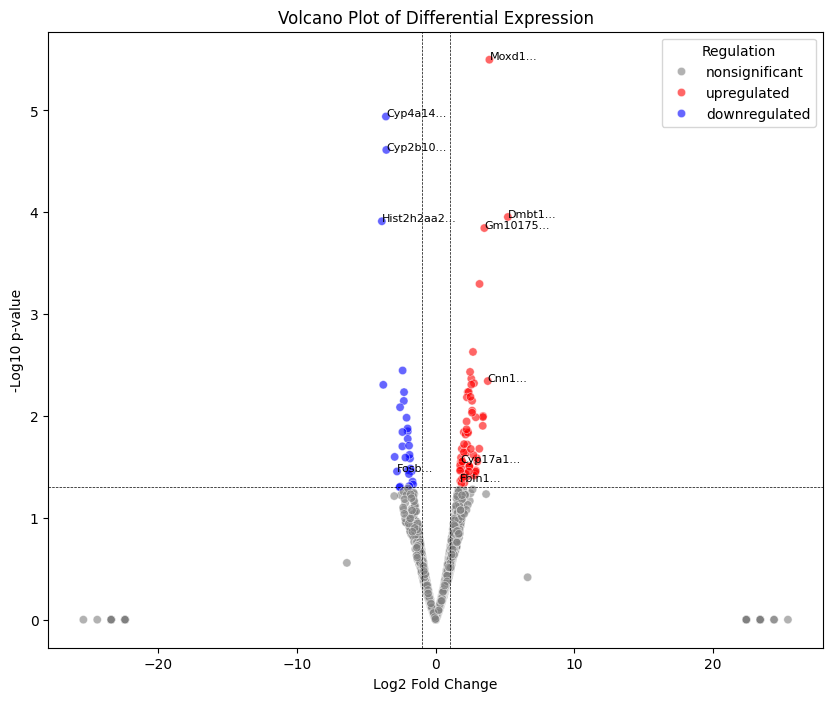

Plotting heatmap...


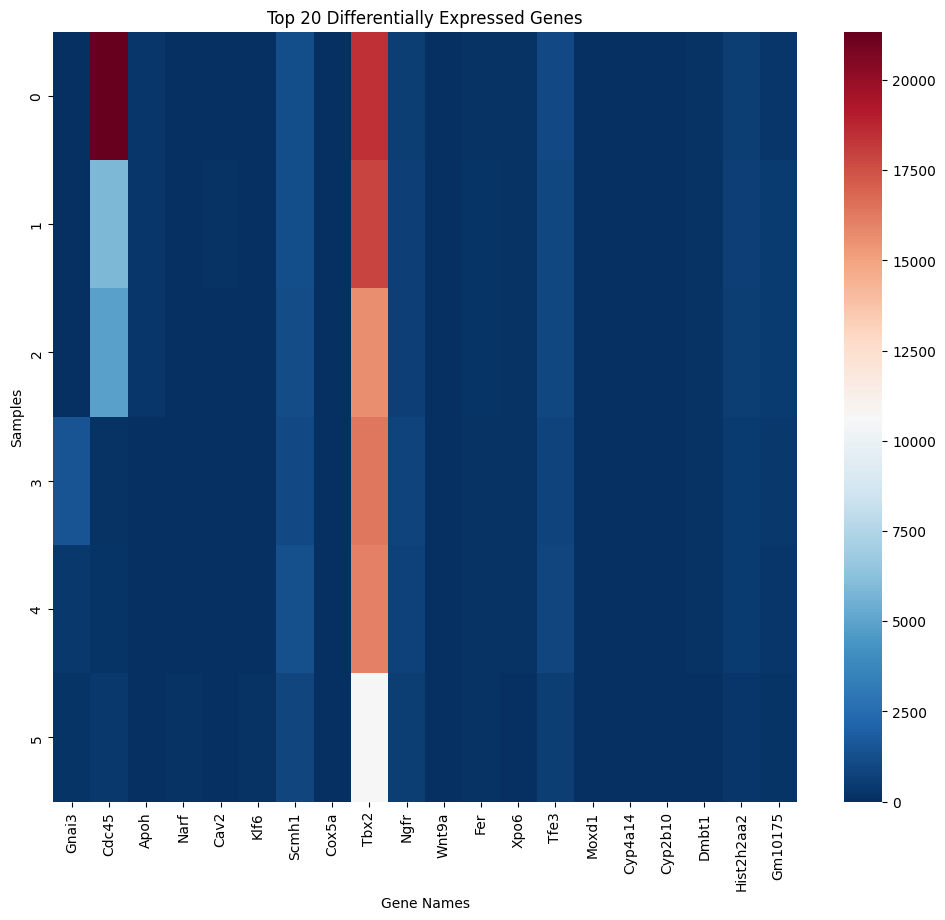

In [13]:
# Visualize differentially expressed genes
print("Plotting Volcano plot...")
# idea.plotVolcano(df_results, contrast[1], contrast[2])
df_results_mapped = idea.map_ensembl_to_gene_name(df_results, 'data/lab4/GRCm38.75.gene_names')
idea.plot_volcano(df_results)

print("Plotting heatmap...")
idea.plot_heatmap(df_results, adata)